In [1]:
from AssignmentQ2_Group5_D import * # Restart kernel if file changed
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from IPython.display import clear_output
clear_output(wait=True)
print("Selected case:", inp)
print('Success, obj:', model.ObjVal) if sol else print('Failed')

Selected case: 5
Success, obj: 320.7038410439445


In [2]:
tol = 1e-6

# Extract solution
solution = []
for v in V:
    print(f"Vehicle {v}:", end=' ')
    route = []
    i = 0
    while True:
        js = [j for j in N if abs(x[i, j, v].X - 1) <= tol]
        assert len(js) <= 1
        if not js: break
        j = int(*js)
        route.append((i, j))
        if j == 0: break
        i = j
    print(', '.join(f"{a:>2} -> {b:<2}" for a, b in route))
    solution.append(route)

Vehicle 0:  0 -> 5 ,  5 -> 14, 14 -> 15, 15 -> 17, 17 -> 13, 13 -> 9 ,  9 -> 11, 11 -> 10, 10 -> 8 ,  8 -> 0 
Vehicle 1: 
Vehicle 2:  0 -> 3 ,  3 -> 2 ,  2 -> 1 ,  1 -> 7 ,  7 -> 4 ,  4 -> 0 
Vehicle 3:  0 -> 20, 20 -> 6 ,  6 -> 18, 18 -> 19, 19 -> 16, 16 -> 12, 12 -> 0 


In [3]:
import pandas as pd
pd.options.display.width = 250
pd.options.display.precision = 2
dfs = {}  # store df per vehicle
total_distance = 0
total_charge_cost = 0
for v, route in enumerate(solution):
    if not route: continue
    data = []
    load = 0
    for i, j in route:
        load += q[i]
        charged = sum(beta_q[i, p, v].X for p in P)
        charge_cost = sum(beta_q[i, p, v].X * cc[p] for p in P)
        data.append({
            'node': f"{i}->{j}",
            'arr_time': tau_a[i, v].X,
            'dep_time': tau_d[i, v].X,
            'travel_time': d[i][j] * s,
            'arr_charge': beta_a[i, v].X,
            'dep_charge': beta_d[i, v].X,
            'charged': charged,
            'charge_cost': charge_cost,
            'has_charger': bs[i],
            'stay_time': tau_d[i, v].X - tau_a[i, v].X,
            # 'charging_time': ", ".join([f"{p}: {tau_ce[i, p, v].X - tau_cs[i, p, v].X:.2f}"
            #     for p in P if abs(beta_c[i, p, v].X) <= tol]),
            'service_time': ts[i],
            'load': load,
        })
        # accumulate totals
        total_distance += d[i][j]
        total_charge_cost += charge_cost
    df = pd.DataFrame(data)
    dfs[v] = pd.DataFrame(data)
    print('vehicle:', v)
    print(df)
    print('\n')

print(f"Total distance traveled: {total_distance:.2f}")
print(f"Total charging cost: {total_charge_cost:.2f}")

vehicle: 0
     node  arr_time  dep_time  travel_time  arr_charge  dep_charge  charged  charge_cost  has_charger  stay_time  service_time  load
0    0->5      0.00      0.00        30.27      140.00      140.00      0.0          0.0            0       0.00             0     0
1   5->14     30.27    120.27        56.57      118.81      118.81      0.0          0.0            0      90.00            90    10
2  14->15    176.83    266.83        10.77       79.22       79.22      0.0          0.0            0      90.00            90    20
3  15->17    277.60    367.60        10.77       71.68       71.68      0.0          0.0            1      90.00            90    60
4  17->13    378.37    468.37         8.00       64.14       64.14      0.0          0.0            0      90.00            90    80
5   13->9    476.37    566.37        15.62       58.54       58.54      0.0          0.0            0      90.00            90   110
6   9->11    582.00    691.00        14.14       47.60    

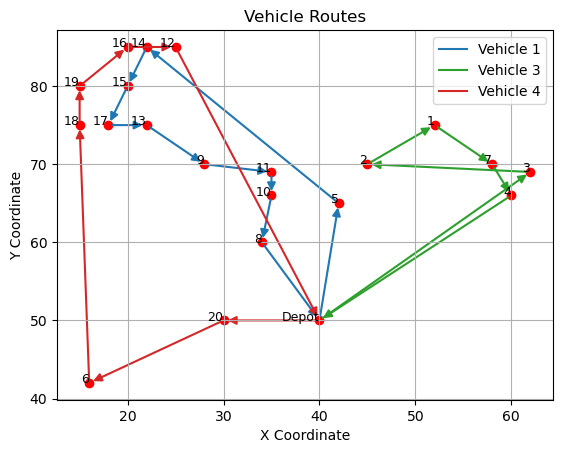

In [4]:
# Plotting points
x_coords = []
y_coords = []
for n in node_data:
    x_coords.append(n.XCOORD)
    y_coords.append(n.YCOORD)
plt.scatter(x_coords, y_coords, color='red')
plt.text(node_data[0].XCOORD, node_data[0].YCOORD, 'Depot', fontsize=9, ha='right')
for i, n in enumerate(node_data[1:], start=1):
    plt.text(n.XCOORD, n.YCOORD, f'{i}', fontsize=9, ha='right')

# Plotting the routes put arrows between the nodes
cmap = plt.get_cmap('tab10')
for v, route in enumerate(solution):
    if not route: 
        continue
    
    color = cmap(v % 10)
    plt.plot([], [], color=color, label=f'Vehicle {v+1}')
    ax = plt.gca()

    for i, j in route:
        x1, y1 = node_data[i].XCOORD, node_data[i].YCOORD
        x2, y2 = node_data[j].XCOORD, node_data[j].YCOORD

        if x1 == x2 and y1 == y2:
            continue

        arr = FancyArrowPatch(
            (x1, y1), (x2, y2),
            arrowstyle='-|>', mutation_scale=12,
            color=color, linewidth=1.5,
            shrinkA=3, shrinkB=3)
        ax.add_patch(arr)

plt.title('Vehicle Routes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid()
plt.show()

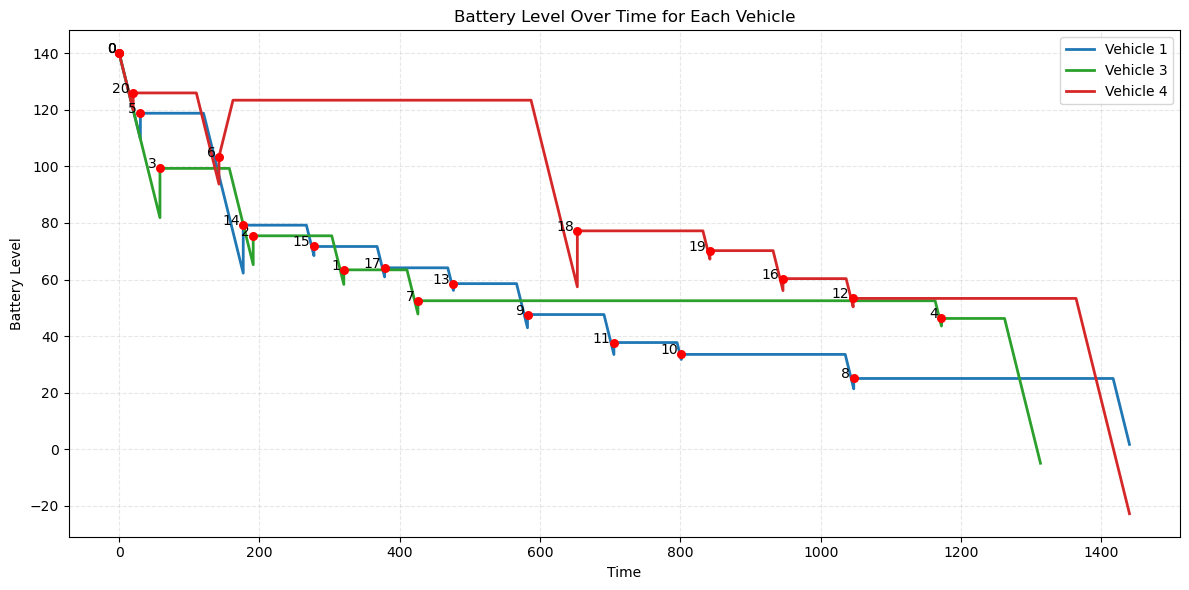

In [5]:
plt.figure(figsize=(12, 6))
cmap = plt.get_cmap('tab10')

for v, df in dfs.items():
    color = cmap(v % 10)

    times = []
    charges = []

    # To store node markers
    node_times = []
    node_charges = []
    node_labels = []

    for idx, row in df.iterrows():

        node_i = int(row['node'].split("->")[0])

        # ---------------------------
        # 1. ARRIVAL POINT (Node marker)
        # ---------------------------
        t = row['arr_time']
        c = row['arr_charge']

        times.append(t)
        charges.append(c)

        node_times.append(t)
        node_charges.append(c)
        node_labels.append(node_i)

        # ---------------------------
        # 2. CHARGING (rate = +1)
        # ---------------------------
        charge_amount = row['charged']
        charge_time = charge_amount  # rate = 1

        if charge_amount > 0:
            t2 = t + charge_time
            c2 = c + charge_amount
            times.append(t2)
            charges.append(c2)
            t, c = t2, c2

        # ---------------------------
        # 3. WAITING (flat)
        # ---------------------------
        total_stay = row['stay_time']
        waiting_time = total_stay - charge_time

        if waiting_time > 0.0001:
            t2 = t + waiting_time
            c2 = c
            times.append(t2)
            charges.append(c2)
            t, c = t2, c2

        # ---------------------------
        # 4. TRAVEL (rate = -1)
        # ---------------------------
        travel_time = row['travel_time']
        discharge_amount = travel_time

        t2 = t + travel_time
        c2 = c - discharge_amount
        times.append(t2)
        charges.append(c2)

        t, c = t2, c2

    # ---- plot the battery line ----
    plt.plot(times, charges, color=color, linewidth=2, label=f"Vehicle {v+1}")

    # ---- add red node markers ----
    plt.scatter(node_times, node_charges, color='red', s=30, zorder=5)

    # ---- node labels ----
    for xt, yt, lab in zip(node_times, node_charges, node_labels):
        plt.text(xt-5, yt, str(lab), fontsize=10, ha='right')

# Formatting
plt.xlabel("Time")
plt.ylabel("Battery Level")
plt.title("Battery Level Over Time for Each Vehicle")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
latex_tables = {}

for v, route in enumerate(solution):
    if not route:
        continue
    
    data = []
    load = 0
    
    for i, j in route:
        load += q[i]

        charged_yes_no = "Yes" if any(beta_q[i, p, v].X > 1e-6 for p in P) else "No"

        data.append({
            'From→To': f"{i}→{j}",
            'Arrival Time': tau_a[i, v].X,
            'Departure Time': tau_d[i, v].X,
            'Travel Time': d[i][j] * s,
            'Battery Arr': beta_a[i, v].X,
            'Battery Dep': beta_d[i, v].X,
            'Charged': charged_yes_no,
            'Load': load
        })

    df = pd.DataFrame(data)

    # number formatting
    df_formatted = df.copy()
    float_cols = ['Arrival Time','Departure Time','Travel Time','Battery Arr','Battery Dep']
    df_formatted[float_cols] = df_formatted[float_cols].applymap(lambda x: f"{x:.2f}")

    # generate LaTeX code
    latex_code = df_formatted.to_latex(
        index=False,
        escape=False,        # allow → symbol
        column_format="lccccccc",
        caption=f"Vehicle {v+1} Route, Times, Load, Battery Levels, and Charging Indicator",
        label=f"tab:vehicle_{v+1}"
    )

    latex_tables[v] = latex_code

    print(f"\n===== LATEX TABLE FOR VEHICLE {v+1} =====\n")
    print(latex_code)



===== LATEX TABLE FOR VEHICLE 1 =====

\begin{table}
\caption{Vehicle 1 Route, Times, Load, Battery Levels, and Charging Indicator}
\label{tab:vehicle_1}
\begin{tabular}{lccccccc}
\toprule
From→To & Arrival Time & Departure Time & Travel Time & Battery Arr & Battery Dep & Charged & Load \\
\midrule
0→5 & 0.00 & 0.00 & 30.27 & 140.00 & 140.00 & No & 0 \\
5→14 & 30.27 & 120.27 & 56.57 & 118.81 & 118.81 & No & 10 \\
14→15 & 176.83 & 266.83 & 10.77 & 79.22 & 79.22 & No & 20 \\
15→17 & 277.60 & 367.60 & 10.77 & 71.68 & 71.68 & No & 60 \\
17→13 & 378.37 & 468.37 & 8.00 & 64.14 & 64.14 & No & 80 \\
13→9 & 476.37 & 566.37 & 15.62 & 58.54 & 58.54 & No & 110 \\
9→11 & 582.00 & 691.00 & 14.14 & 47.60 & 47.60 & No & 120 \\
11→10 & 705.14 & 795.14 & 6.00 & 37.70 & 37.70 & No & 130 \\
10→8 & 801.14 & 1034.83 & 12.17 & 33.50 & 33.50 & No & 140 \\
8→0 & 1047.00 & 1416.68 & 23.32 & 24.99 & 24.99 & No & 160 \\
\bottomrule
\end{tabular}
\end{table}


===== LATEX TABLE FOR VEHICLE 3 =====

\begin{table}


C:\Users\allee\AppData\Local\Temp\ipykernel_22936\3930759756.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_formatted[float_cols] = df_formatted[float_cols].applymap(lambda x: f"{x:.2f}")
C:\Users\allee\AppData\Local\Temp\ipykernel_22936\3930759756.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_formatted[float_cols] = df_formatted[float_cols].applymap(lambda x: f"{x:.2f}")
C:\Users\allee\AppData\Local\Temp\ipykernel_22936\3930759756.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_formatted[float_cols] = df_formatted[float_cols].applymap(lambda x: f"{x:.2f}")
